In [1]:
import numpy as np
import scipy.stats
import pandas as pd
import os
from sklearn.metrics import (roc_curve, accuracy_score, log_loss, 
                            balanced_accuracy_score, confusion_matrix, 
                            roc_auc_score, make_scorer, precision_score, recall_score,
                            average_precision_score, precision_recall_curve, roc_curve)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.25)

In [16]:
# choose from v20210909(med administration) and v20210921_labs_vitals_only(no meds), and v20210930 (med orders) 


results_dir = '/home/prash/results/madrid/v20210930/HUF/split-by=patient_id/collapsed_features_dynamic_input_output'
clf_train_test_split_dir = '/home/prash/datasets/v20210930/HUF/split-by=patient_id/collapsed_features_dynamic_input_output/classifier_train_test_split'
huf_df = pd.read_pickle(os.path.join(results_dir, "alarm_stats.csv"))

# rnn_results_dir = '/home/prash/results/madrid/v20210930/HUF/split-by=patient_id/features_per_timestep'
# huf_rnn_df = pd.read_pickle(os.path.join(rnn_results_dir, "rnn_alarm_stats.csv"))


# huf_df = pd.concat([huf_df, huf_rnn_df])


y_train_df = pd.read_csv(os.path.join(clf_train_test_split_dir, 'y_train.csv.gz'))
y_valid_df = pd.read_csv(os.path.join(clf_train_test_split_dir, 'y_valid.csv.gz'))
y_test_df = pd.read_csv(os.path.join(clf_train_test_split_dir, 'y_test.csv.gz'))

y_train = np.ravel(y_train_df['clinical_deterioration_outcome'].values)
y_valid = np.ravel(y_valid_df['clinical_deterioration_outcome'].values)
y_test = np.ravel(y_test_df['clinical_deterioration_outcome'].values)

<ipython-input-17-9144db9d50a3>:86: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  pr_f_tr.savefig('pr_curve_train_with_med_orders.png', bbox_inches='tight', pad_inches=0)
<ipython-input-17-9144db9d50a3>:87: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  pr_f_va.savefig('pr_curve_valid_with_med_orders.png', bbox_inches='tight', pad_inches=0)
/home/prash/.conda/envs/madrid_data_prep/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


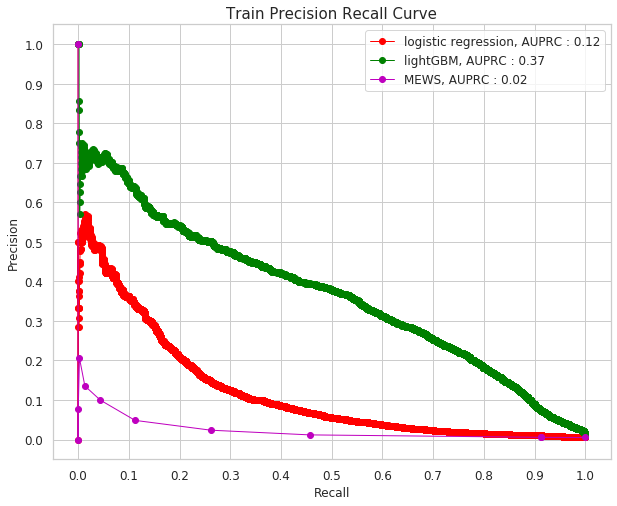

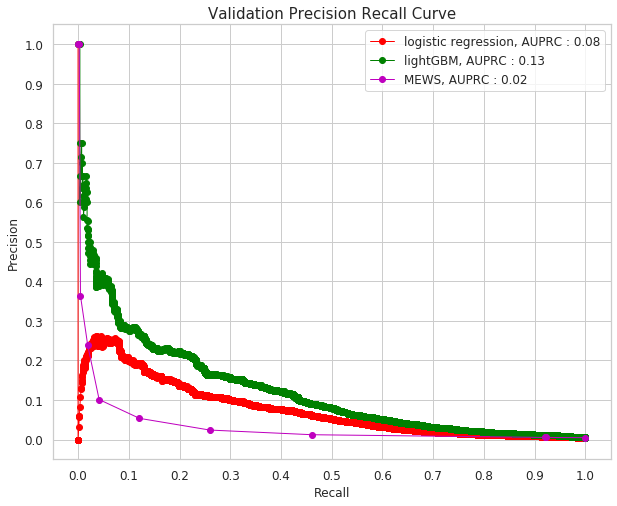

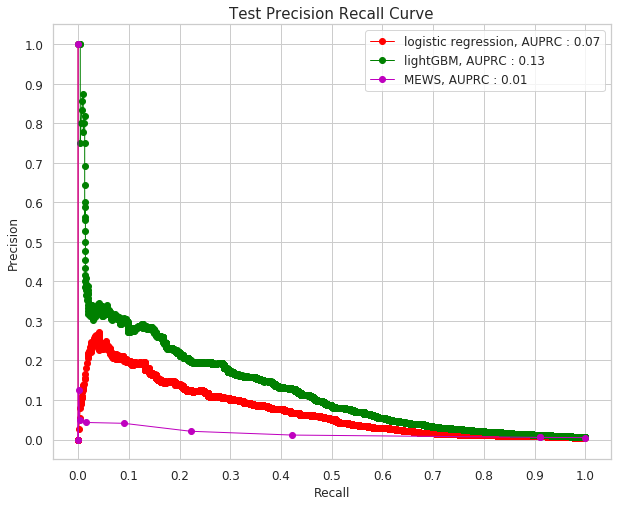

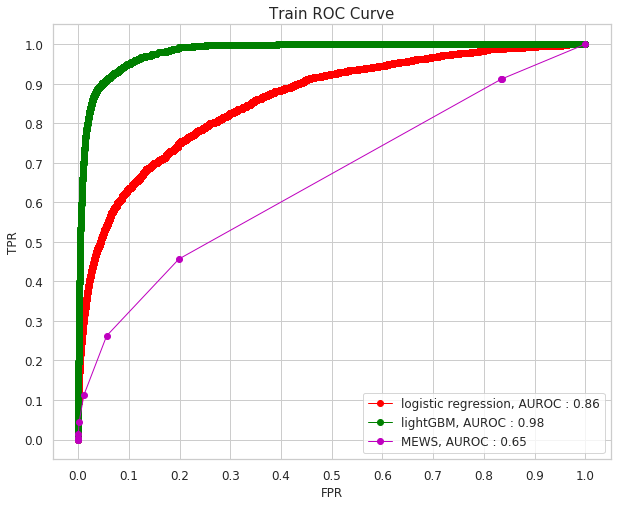

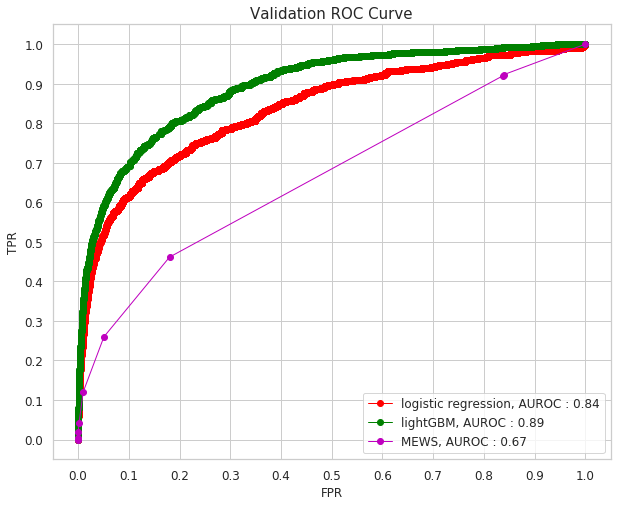

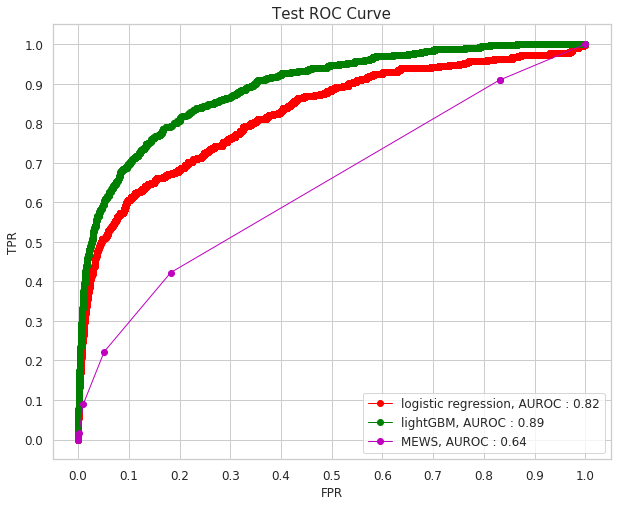

In [17]:
full_ds_df = pd.read_pickle(os.path.join(results_dir, "performance_of_best_clfs.pkl"))

# rnn_full_ds_df = pd.read_pickle(os.path.join(rnn_results_dir, "performance_of_best_rnn.pkl"))
# full_ds_df = pd.concat([full_ds_df, rnn_full_ds_df])

models_dict = {
    'logistic regression' : {'dirname':'skorch_logistic_regression', 
                                       'model_color' : 'r', 
                                       'model_marker' : 's'},
             'lightGBM' : {'dirname': 'lightGBM',
                                'model_color' : 'g',
                                'model_marker' : 'o'},
              'MEWS' : {'dirname' : None,
                               'model_color' : 'm',
                              'model_marker' : '.'},
#              'GRU-RNN' : {'dirname':'rnn_per_tstep', 
#                           'model_color' : 'k', 
#                           'model_marker' : 's'},
              }

pr_f_tr, pr_axs_tr = plt.subplots(1, 1, figsize=(10, 8))
pr_f_va, pr_axs_va = plt.subplots(1, 1, figsize=(10, 8))
pr_f_te, pr_axs_te = plt.subplots(1, 1, figsize=(10, 8))
auc_f_tr, auc_axs_tr = plt.subplots(1, 1, figsize=(10, 8))
auc_f_va, auc_axs_va = plt.subplots(1, 1, figsize=(10, 8))
auc_f_te, auc_axs_te = plt.subplots(1, 1, figsize=(10, 8))

for model_name in models_dict.keys():
    
    model_ind = full_ds_df['model']==model_name
    y_train_proba_vals = full_ds_df.loc[model_ind, 'best_model_train_pred_probas'].values[0]
    y_valid_proba_vals = full_ds_df.loc[model_ind, 'best_model_valid_pred_probas'].values[0]
    y_test_proba_vals = full_ds_df.loc[model_ind, 'best_model_test_pred_probas'].values[0]
    
    
    best_model_auprc_train = average_precision_score(y_train, y_train_proba_vals)
    best_model_auprc_valid = average_precision_score(y_valid, y_valid_proba_vals)
    best_model_auprc_test = average_precision_score(y_test, y_test_proba_vals)

    best_model_auroc_train = roc_auc_score(y_train, y_train_proba_vals)
    best_model_auroc_valid = roc_auc_score(y_valid, y_valid_proba_vals)
    best_model_auroc_test = roc_auc_score(y_test, y_test_proba_vals)
    
    
    # create the precision recall plot
    precs_train, recs_train, thresholds_train = precision_recall_curve(y_train, y_train_proba_vals)
    precs_valid, recs_valid, thresholds_valid = precision_recall_curve(y_valid, y_valid_proba_vals)
    precs_test, recs_test, thresholds_test = precision_recall_curve(y_test, y_test_proba_vals)  

    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_proba_vals)
    fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_proba_vals)
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_proba_vals)

    linewidth=1.0
    pr_axs_tr.plot(recs_train, precs_train, models_dict[model_name]['model_color']+'-o', label = '%s, AUPRC : %.2f'%(model_name, best_model_auprc_train), linewidth=linewidth)

    pr_axs_va.plot(recs_valid, precs_valid, models_dict[model_name]['model_color']+'-o', label = '%s, AUPRC : %.2f'%(model_name, best_model_auprc_valid), linewidth=linewidth)

    pr_axs_te.plot(recs_test, precs_test, models_dict[model_name]['model_color']+'-o', label = '%s, AUPRC : %.2f'%(model_name, best_model_auprc_test), linewidth=linewidth)

    auc_axs_tr.plot(fpr_train, tpr_train, models_dict[model_name]['model_color']+'-o', label = '%s, AUROC : %.2f'%(model_name, best_model_auroc_train), linewidth=linewidth)

    auc_axs_va.plot(fpr_valid, tpr_valid, models_dict[model_name]['model_color']+'-o', label = '%s, AUROC : %.2f'%(model_name, best_model_auroc_valid), linewidth=linewidth)

    auc_axs_te.plot(fpr_test, tpr_test, models_dict[model_name]['model_color']+'-o', label = '%s, AUROC : %.2f'%(model_name, best_model_auroc_test), linewidth=linewidth)


ticks = np.arange(0.0, 1.1, 0.1)
ticklabels = ['%.1f'%x for x in ticks]
lims = [-0.05, 1.05]
fontsize = 12
for (ax, ax_title) in [(pr_axs_tr, 'Train Precision Recall Curve'), 
                       (pr_axs_va, 'Validation Precision Recall Curve'),
                       (pr_axs_te, 'Test Precision Recall Curve')]:
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticklabels, fontsize=fontsize)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticklabels, fontsize=fontsize)
    ax.set_title(ax_title, fontsize = fontsize+3)
    ax.legend(fontsize=fontsize)
    ax.set_xlabel('Recall', fontsize=fontsize)
    ax.set_ylabel('Precision', fontsize=fontsize)
    ax.set_xlim(lims)
    ax.set_ylim(lims)

pr_f_tr.savefig('pr_curve_train_with_med_orders.png', bbox_inches='tight', pad_inches=0)
pr_f_va.savefig('pr_curve_valid_with_med_orders.png', bbox_inches='tight', pad_inches=0)
pr_f_te.savefig('pr_curve_test_with_med_orders.png', bbox_inches='tight', pad_inches=0)

for (ax, ax_title) in [(auc_axs_tr, 'Train ROC Curve'), 
                       (auc_axs_va, 'Validation ROC Curve'),
                       (auc_axs_te, 'Test ROC Curve')]:
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticklabels, fontsize=fontsize)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticklabels, fontsize=fontsize)
    ax.set_title(ax_title, fontsize = fontsize+3)
    ax.legend(fontsize=fontsize)
    ax.set_xlabel('FPR', fontsize=fontsize)
    ax.set_ylabel('TPR', fontsize=fontsize)
    ax.set_xlim(lims)
    ax.set_ylim(lims)

auc_f_tr.savefig('roc_curve_train_with_med_orders.png', bbox_inches='tight', pad_inches=0)
auc_f_va.savefig('roc_curve_valid_with_med_orders.png', bbox_inches='tight', pad_inches=0)
auc_f_te.savefig('roc_curve_test_with_med_orders.png', bbox_inches='tight', pad_inches=0)    

# print('Saved pr, roc curves on train, valid, test to : %s'%args.output_dir)

In [10]:
full_ds_df['best_model_file'][1]

'/home/prash/results/madrid/v20210930/HUF/split-by=patient_id/collapsed_features_dynamic_input_output/lightGBM/lightGBM_min_samples_per_leaf=128-max_leaves=32-n_estimators=100-frac_features_for_clf=0.66-frac_training_samples_per_tree=0.66.onnx'

In [8]:
y_train_proba_vals[0].shape

()

In [7]:
W = 55   # number of weeks
G = 1000 # number of thresholds

In [6]:
color_map = {
    'MEWS':'m',
    'logistic regression': 'b',
    'lightGBM': 'r',
    'GRU-RNN' : 'k'
    }

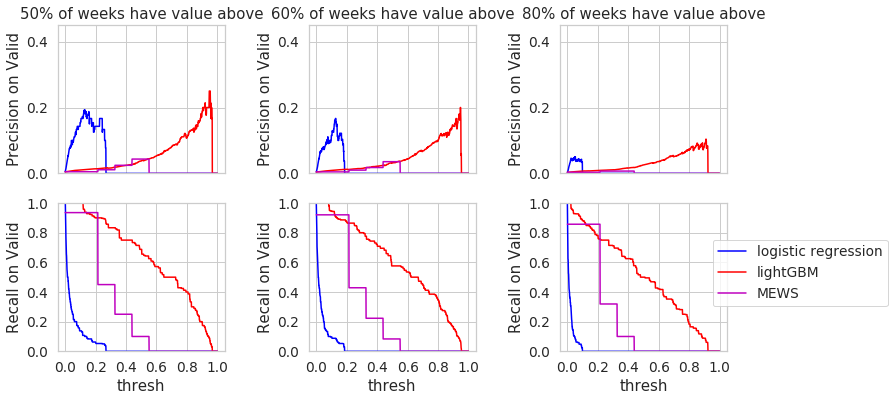

In [18]:
prec_ymax = 0.45;
recall_ymax = 1.0;
ticks = [0.0, .2, .4, .6, .8, 1.0]

f, axgrid = plt.subplots(
    nrows=2, ncols=3, sharex=True, sharey=False,
    figsize=(12, 6));

prec_and_recall_by_model = dict()

for model in models_dict.keys():
    
    for split in ['valid', 'test']:
        model_df = huf_df.query("model == '%s' and split == '%s'" % (model,split)).reset_index().copy()
    
        thresh_G = model_df['threshold_grid'].values[0]
        minval = thresh_G.min()
        maxval = thresh_G.max()
        thresh_G = (thresh_G - minval) / (maxval - minval) # ensure thresholds go from 0 to 1 for clean viz
    
        TP_WG = model_df['TP_arr'].values[0]
        FP_WG = model_df['FP_arr'].values[0]
        TN_WG = model_df['TN_arr'].values[0]
        FN_WG = model_df['FN_arr'].values[0]

        prec_WG = TP_WG / (1e-10 + TP_WG + FP_WG)
        recall_WG = TP_WG / (1e-10 + TP_WG + FN_WG)
    
        if split == 'test':
            prec_and_recall_by_model[model]['test_thresh'] = thresh_G
            prec_and_recall_by_model[model]['test_prec'] = prec_WG.copy()
            prec_and_recall_by_model[model]['test_recall'] = recall_WG.copy()
        else:
            prec_and_recall_by_model[model] = dict(
                thresh=thresh_G, prec=prec_WG.copy(), recall=recall_WG.copy())
        
        if split == 'valid':
            for pp, perc in enumerate([50, 60, 80]):
                if pp == 2:
                    label = str(model).replace("_", " ")
                else:
                    label = ''
                axgrid[0,pp].plot(
                    thresh_G, np.percentile(prec_WG, 100-perc, axis=0),
                    label=label,
                    color=color_map[model]);
                axgrid[0,pp].set_ylabel('Precision on Valid')
                axgrid[0,pp].set_xticks(ticks)
                axgrid[0,pp].set_yticks(ticks)
                axgrid[0,pp].set_ylim([0, prec_ymax]);
                axgrid[0,pp].set_title("%.0f%% of weeks have value above" % perc)

                axgrid[1,pp].plot(
                    thresh_G, np.percentile(recall_WG, 100-perc, axis=0),
                    label=label,
                    color=color_map[model]);
                axgrid[1,pp].set_ylabel('Recall on Valid')
                axgrid[1,pp].set_xlabel('thresh')

                axgrid[1,pp].set_xticks(ticks)
                axgrid[1,pp].set_yticks(ticks)
                axgrid[1,pp].set_ylim([0, recall_ymax]);
                
        plt.legend(bbox_to_anchor=(2.0, 0.8));
        
plt.subplots_adjust(wspace=0.5);
f.savefig('precision_recall_weeks_across_thresholds_with_med_orders.png', bbox_inches='tight', pad_inches=0)

## Select ideal threshold for each possible desired precision

Selection strategy:

On the VALIDATION set, compute the precision and recall that MAJORITY of all 1-week intervals reach.

Try each possible desired precision from 0.2, 0.19, 0.18, 0.17, .... down to 0.0

At each one, either:

* Determine that it is INFEASIBLE : no threshold will reach it
* Determine that it is FEASIBLE and select among all thresholds that reach it, the one that maximizes recall 

We'll then be able to make plots showing all FEASIBLE thresholds

In [19]:
ideal_precision = 0.2
tolerated_precisions = np.arange(0.0, ideal_precision, 0.002)[::-1]

target_percentile = 80 # majority is defined as 80% of all weeks

row_dict_list = list()

def summarize(a_WG):
    return np.percentile(a_WG, 100 - target_percentile, axis=0)

for model in models_dict.keys():
    thresh_G = prec_and_recall_by_model[model]['thresh']
    prec_WG   = prec_and_recall_by_model[model]['prec']
    recall_WG = prec_and_recall_by_model[model]['recall']

    prec_at_target_perc_G = summarize(prec_WG)
    recall_at_target_perc_G = summarize(recall_WG)

    best_id = None
    for cur_eps in tolerated_precisions:

        mask_G = prec_at_target_perc_G >= cur_eps
        if np.sum(mask_G) > 0.0:
            best_id = np.argmax(recall_at_target_perc_G[mask_G])
            best_thresh = thresh_G[mask_G][best_id]
            best_precision = prec_at_target_perc_G[mask_G][best_id]
            best_recall = recall_at_target_perc_G[mask_G][best_id]
            row_dict_list.append(
                dict(
                    model=model, split='valid',
                    desired_eps=cur_eps,
                    thresh=best_thresh,
                    prec=best_precision,
                    recall=best_recall,
                    target_percentile=target_percentile,
                ))

target_perf_df = pd.DataFrame(row_dict_list)
print(target_perf_df.to_string(index=False, float_format='%.3f'))

               model  split  desired_eps  thresh  prec  recall  target_percentile
 logistic regression  valid        0.050   0.052 0.051   0.083                 80
 logistic regression  valid        0.048   0.048 0.050   0.099                 80
 logistic regression  valid        0.046   0.024 0.046   0.285                 80
 logistic regression  valid        0.044   0.024 0.046   0.285                 80
 logistic regression  valid        0.042   0.022 0.042   0.306                 80
 logistic regression  valid        0.040   0.022 0.042   0.306                 80
 logistic regression  valid        0.038   0.021 0.040   0.306                 80
 logistic regression  valid        0.036   0.020 0.038   0.331                 80
 logistic regression  valid        0.034   0.019 0.035   0.331                 80
 logistic regression  valid        0.032   0.018 0.033   0.358                 80
 logistic regression  valid        0.030   0.016 0.031   0.367                 80
 logistic regres

## Visualize the performance at the chosen thresholds


In [20]:
row_dict_list = list()

# Always put the target percentile (used to select thresholds) first
for percentile_to_try in [80.0, 60.0, 40.0, 20.0, 0.0]:

    def assess_perf_at_fixed_thresh(thr, thresh_G, prec_WG, recall_WG, perc):
        prec_G = np.percentile(prec_WG, 100 - perc, axis=0)
        recall_G = np.percentile(recall_WG, 100 - perc, axis=0)
        gg = np.searchsorted(thresh_G, thr)
        return dict(
            prec=prec_G[gg],
            recall=recall_G[gg],
            )
    
    for model in models_dict.keys():
        a_df = target_perf_df.query(
            "model == '%s'" % (model))
        
        cur_eps_list = a_df['desired_eps'].unique()
        for cur_eps in cur_eps_list:
            b_df = a_df.query("desired_eps == %s" % cur_eps)
            assert b_df.shape[0] == 1
            thresh = float(b_df['thresh'].values[0])

            valid_row_dict = dict(
                    model=model, split='valid',
                    desired_eps=cur_eps,
                    thresh=thresh,
                    target_percentile=percentile_to_try,
                    )
            valid_row_dict.update(
                assess_perf_at_fixed_thresh(
                    thresh, thresh_G,
                    prec_and_recall_by_model[model]['prec'],
                    prec_and_recall_by_model[model]['recall'],
                    percentile_to_try))
            row_dict_list.append(valid_row_dict)
            
            test_row_dict = dict(
                    model=model, split='test',
                    desired_eps=cur_eps,
                    thresh=thresh,
                    target_percentile=percentile_to_try,
                    )
            test_row_dict.update(
                assess_perf_at_fixed_thresh(
                    thresh, thresh_G,
                    prec_and_recall_by_model[model]['test_prec'],
                    prec_and_recall_by_model[model]['test_recall'],
                    percentile_to_try))
            row_dict_list.append(test_row_dict)

all_perf_df = pd.DataFrame(row_dict_list)
print(all_perf_df.to_string(index=False, float_format='%.3f'))

               model  split  desired_eps  thresh  target_percentile  prec  recall
 logistic regression  valid        0.050   0.052             80.000 0.051   0.083
 logistic regression   test        0.050   0.052             80.000 0.053   0.162
 logistic regression  valid        0.048   0.048             80.000 0.050   0.099
 logistic regression   test        0.048   0.048             80.000 0.051   0.193
 logistic regression  valid        0.046   0.024             80.000 0.046   0.285
 logistic regression   test        0.046   0.024             80.000 0.033   0.303
 logistic regression  valid        0.044   0.024             80.000 0.046   0.285
 logistic regression   test        0.044   0.024             80.000 0.033   0.303
 logistic regression  valid        0.042   0.022             80.000 0.042   0.306
 logistic regression   test        0.042   0.022             80.000 0.033   0.333
 logistic regression  valid        0.040   0.022             80.000 0.042   0.306
 logistic regres

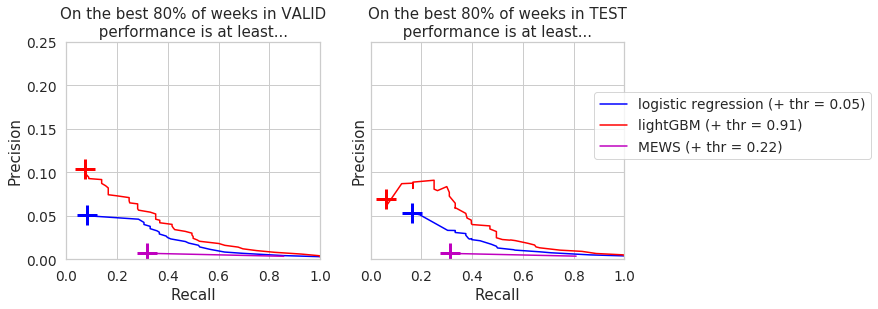

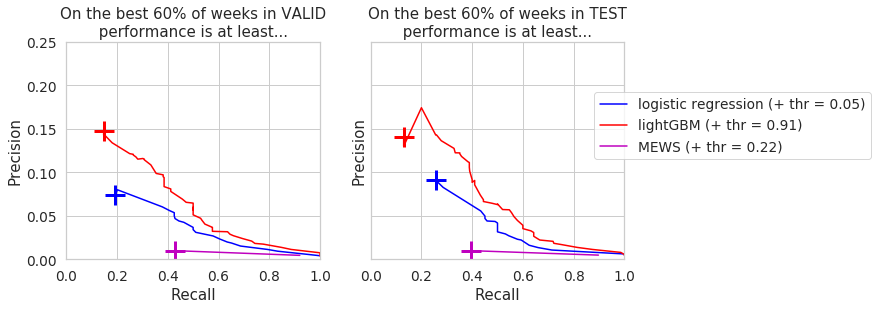

In [21]:
#precision_ymax = 1.0
#for target_percentile in [80.0, 60., 40., 20, 0]:

precision_ymax = 0.25
for target_percentile in [80.0, 60.]:
    f, axgrid = plt.subplots(nrows=1, ncols=2, figsize=(10,4), sharex=True, sharey=True)

    for ss, split in enumerate(['valid', 'test']):
        ax = axgrid[ss]
        ax.set_title("On the best %.0f%% of weeks in %s\n performance is at least... " % (
            target_percentile, split.upper()));

        for model in models_dict.keys():
            row_df = all_perf_df.query(
                "model == '%s' and split == '%s' and target_percentile == %f" % (model, split, target_percentile))
            assert row_df.shape[0] >= 1
            
#             precs = row_df['prec'].values
#             recs = row_df['recall'].values
            
#             if split=='valid':
#                 keep_inds = precs>=row_df['desired_eps'].values[0]
#                 best_ind = np.argmax(recs[keep_inds])
#                 chosen_thresh = row_df['thresh'].values[keep_inds][best_ind]
                
#             best_prec = precs[keep_inds][best_ind]
#             best_rec = recs[keep_inds][best_ind]
            
            ax.plot(
                row_df['recall'].values[0], row_df['prec'].values[0], '+',
                markersize=20, mew=3, color=color_map[model])
            ax.plot(
                row_df['recall'], row_df['prec'], '-',
                label=model + " (+ thr = %.2f)" % row_df['thresh'].values[0], markersize=10, color=color_map[model])

        ax.set_ylabel('Precision')
        ax.set_xlabel('Recall')
        ax.set_ylim([0.0, precision_ymax]);
        ax.set_xlim([0.0, 1.0]);
    plt.legend(bbox_to_anchor=(2.0, 0.8));
    
    f.savefig('min_precision_recall_%s_perc_weeks_with_med_orders.png'%(int(target_percentile)), bbox_inches='tight', pad_inches=0)

# Confusion matrices

In [13]:
for model in models_dict.keys():
    for ss, split in enumerate(['valid', 'test']):

        cur_perf_df = all_perf_df.query(
            "model == '%s' and split == '%s'" % (model, split))
        thresh = cur_perf_df['thresh'].values[0]
        
        cur_huf_df = huf_df.query(
            "model == '%s' and split == '%s'" % (model, split))
        orig_id = np.searchsorted(cur_huf_df['threshold_grid'].values[0], thresh)
        
        row_dict_list = list()
        
        conf_mat_22 = np.zeros((2,2), dtype=np.int32)
        for kk, key in enumerate(['TN_arr', 'FP_arr']):
            count = cur_huf_df[key].values[0][:, orig_id].sum()
            conf_mat_22[0, kk] = count
        for kk, key in enumerate(['FN_arr', 'TP_arr']):
            count = cur_huf_df[key].values[0][:, orig_id].sum()
            conf_mat_22[1, kk] = count

        def make_cm_df_from_arr(arr_22):
            cm_df = pd.DataFrame(arr_22, columns=[0,1], index=[0,1])
            cm_df.columns.name = 'Predicted label'
            cm_df.index.name = 'True label'        
            return cm_df
            
        pd.set_option('precision', 3)
        print("========================== %s %s" % (split.upper(), model))
        print(make_cm_df_from_arr(conf_mat_22))
        print()
        
        for axis in [0, 1]:
            normed_22 = conf_mat_22 / conf_mat_22.sum(axis=axis, keepdims=1)
            print(make_cm_df_from_arr(normed_22))
            print()

========================== VALID logistic regression
Predicted label       0    1
True label                  
0                174724  480
1                   713  130

Predicted label      0      1
True label                   
0                0.996  0.787
1                0.004  0.213

Predicted label      0      1
True label                   
0                0.997  0.003
1                0.846  0.154

========================== TEST logistic regression
Predicted label       0    1
True label                  
0                138645  519
1                   567  122

Predicted label      0     1
True label                  
0                0.996  0.81
1                0.004  0.19

Predicted label      0      1
True label                   
0                0.996  0.004
1                0.823  0.177

========================== VALID lightGBM
Predicted label       0    1
True label                  
0                174747  457
1                   665  178

Predicted label      0

# Week - by - week performance

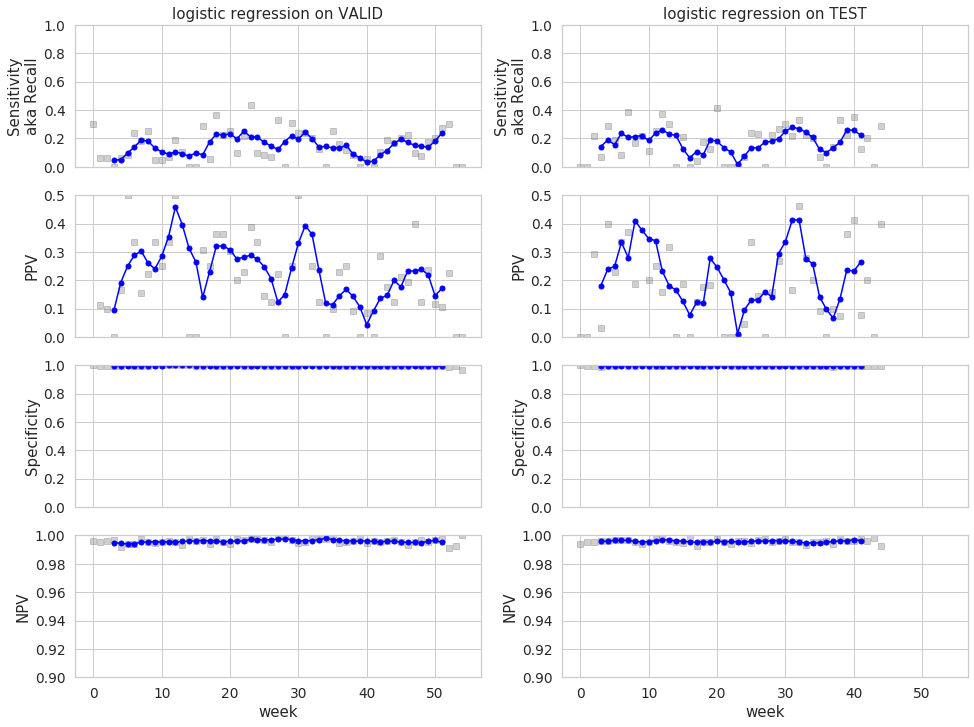

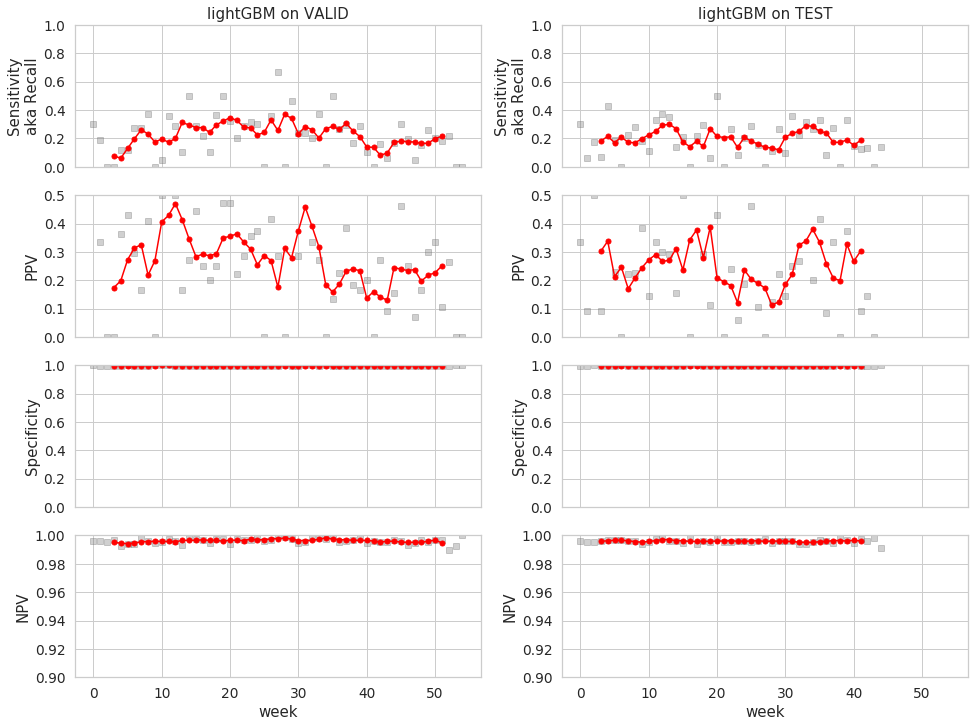

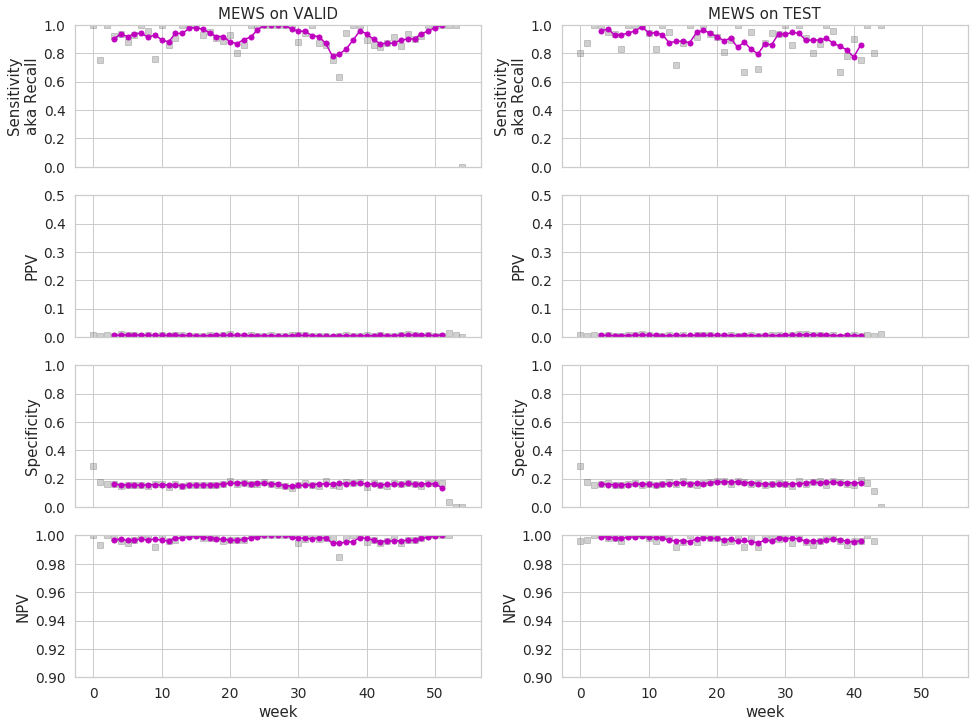

In [14]:
ylim_by_metric = dict(
    PPV=(0.0, 0.5),
    NPV=(0.9, 1.0),
    Specificity=(0.0, 1.0),
    Sensitivity=(0.0, 1.0),
    )

for model in models_dict.keys():
        
    _, axgrid = plt.subplots(nrows=4, ncols=2, figsize=(16, 12), sharex=True, sharey=False)

    for ss, split in enumerate(['valid', 'test']):
        cur_perf_df = all_perf_df.query(
            "model == '%s' and split == '%s'" % (model, split))
        thresh = cur_perf_df['thresh'].values[0]
        
        cur_huf_df = huf_df.query(
            "model == '%s' and split == '%s'" % (model, split))
        orig_id = np.searchsorted(cur_huf_df['threshold_grid'].values[0], thresh)
        
        perf_W_by_key = dict()
        for key in ['TN', 'FP', 'FN', 'TP']:
            perf_W_by_key[key] = cur_huf_df[key + "_arr"].values[0][:,orig_id]
            
        ppv_W = perf_W_by_key['TP'] / (1e-10 + perf_W_by_key['TP'] + perf_W_by_key['FP'])
        npv_W = perf_W_by_key['TN'] / (1e-10 + perf_W_by_key['TN'] + perf_W_by_key['FN'])

        recall1_W = perf_W_by_key['TP'] / (1e-10 + perf_W_by_key['TP'] + perf_W_by_key['FN'])
        recall0_W = perf_W_by_key['TN'] / (1e-10 + perf_W_by_key['TN'] + perf_W_by_key['FP'])
        
        ts_W = np.arange(ppv_W.size)
        for aa, (label, arr_W) in enumerate([
                ('Sensitivity\naka Recall', recall1_W), ('PPV', ppv_W), ('Specificity', recall0_W), ('NPV', npv_W)]):
            ax = axgrid[aa, ss]
            ax.plot(ts_W, arr_W, 's', color='#666666', alpha=0.3, label='raw')
            ax.plot(
                ts_W[3:-3], np.convolve(arr_W, 0.25 * np.ones(4), mode='same')[3:-3],
                '.-', color=color_map[model], markersize=10, label='4 week average')
            ax.set_ylabel(label)
            ax.set_ylim(ylim_by_metric[label.split('\n')[0]])
        
        axgrid[-1,ss].set_xlabel('week')
        axgrid[0,ss].set_title("%s on %s" % (model, split.upper()))
    

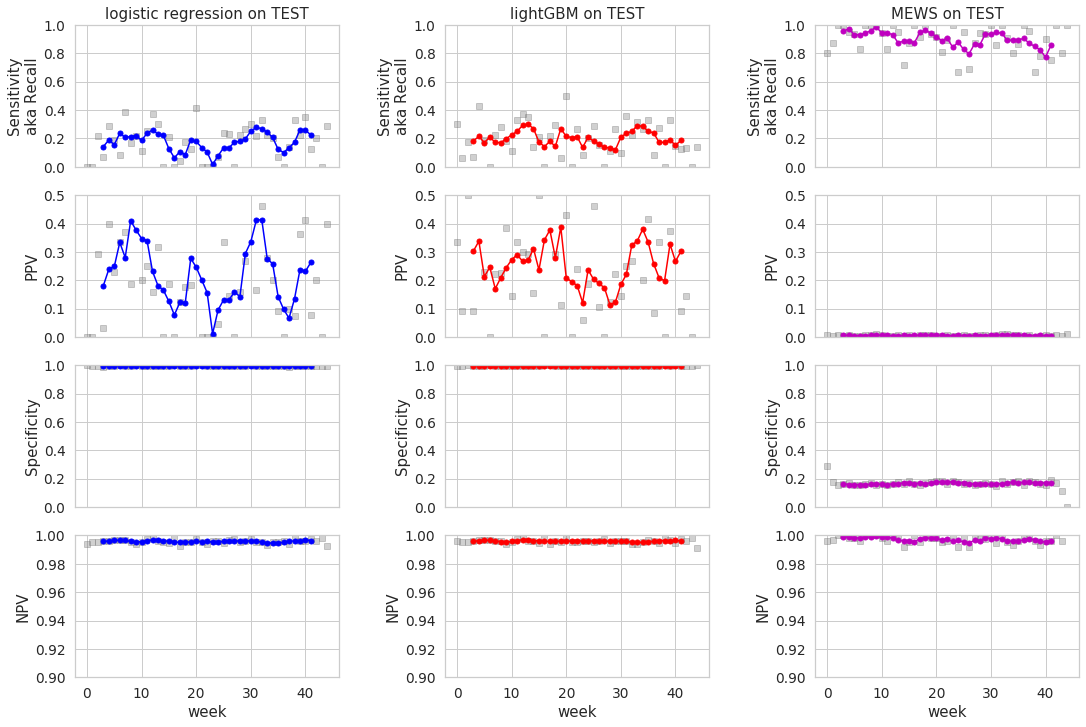

In [15]:
ylim_by_metric = dict(
    PPV=(0.0, 0.5),
    NPV=(0.9, 1.0),
    Specificity=(0.0, 1.0),
    Sensitivity=(0.0, 1.0),
    )

f, axgrid = plt.subplots(nrows=4, ncols=3, figsize=(18, 12), sharex=True, sharey=False)
for mm, model in enumerate(models_dict.keys()):

    for ss, split in enumerate(['test']):
        cur_perf_df = all_perf_df.query(
            "model == '%s' and split == '%s'" % (model, split))
        thresh = cur_perf_df['thresh'].values[0]
        
        cur_huf_df = huf_df.query(
            "model == '%s' and split == '%s'" % (model, split))
        orig_id = np.searchsorted(cur_huf_df['threshold_grid'].values[0], thresh)
        
        perf_W_by_key = dict()
        for key in ['TN', 'FP', 'FN', 'TP']:
            perf_W_by_key[key] = cur_huf_df[key + "_arr"].values[0][:,orig_id]
            
        ppv_W = perf_W_by_key['TP'] / (1e-10 + perf_W_by_key['TP'] + perf_W_by_key['FP'])
        npv_W = perf_W_by_key['TN'] / (1e-10 + perf_W_by_key['TN'] + perf_W_by_key['FN'])

        recall1_W = perf_W_by_key['TP'] / (1e-10 + perf_W_by_key['TP'] + perf_W_by_key['FN'])
        recall0_W = perf_W_by_key['TN'] / (1e-10 + perf_W_by_key['TN'] + perf_W_by_key['FP'])
        
        ts_W = np.arange(ppv_W.size)
        for aa, (label, arr_W) in enumerate([
                ('Sensitivity\naka Recall', recall1_W), ('PPV', ppv_W), ('Specificity', recall0_W), ('NPV', npv_W)]):
            ax = axgrid[aa, mm]
            ax.plot(ts_W, arr_W, 's', color='#666666', alpha=0.3, label='raw')
            ax.plot(
                ts_W[3:-3], np.convolve(arr_W, 0.25 * np.ones(4), mode='same')[3:-3],
                '.-', color=color_map[model], markersize=10, label='4 week average')
            ax.set_ylabel(label)
            ax.set_ylim(ylim_by_metric[label.split('\n')[0]])
        
        axgrid[-1, mm].set_xlabel('week')
        axgrid[0, mm].set_title("%s on %s" % (model, split.upper()))
        plt.subplots_adjust(wspace=0.4);
        
f.savefig('performance_over_weeks_with_med_orders.png', bbox_inches='tight', pad_inches=0)